In [25]:
import numpy as np
import itertools

rng = np.random.default_rng()

In [26]:
class Environment:
    _id_iter = itertools.count()

    def __init__(self, functions, dynamicity=0.0, M=1):
        """
        functions: list of functions that take an array of length M and return a scalar
        dynamicity: probability of rotating/changing the functions each generation
        """
        self.id = next(Environment._id_iter)
        self.M = M
        self.dynamicity = dynamicity
        self.functions = functions
        self.active_function = self.functions[0]
        
        self.inputs = self.sample_inputs()
        self.compute_targets()

        

    def sample_inputs(self):
        """Random inputs for genome -> output mapping."""
        return rng.uniform(3, 5, size=self.M)

    def compute_targets(self):
        """Compute target outputs for current inputs."""
        self.targets = self.active_function(self.inputs)

    def update(self):
        """If dynamic, possibly rotate functions and change inputs."""
        if rng.random() < self.dynamicity:
            self.active_function = self.functions[rng.integers(len(functions))]
            self.inputs = self.sample_inputs()
        self.compute_targets()

In [27]:
def f1(x): return x**2
def f2(x): return x + x**3

env1 = Environment([f1], dynamicity=0.0)
env2 = Environment([f2], dynamicity=0.0)

In [28]:
env1.compute_targets()
env1.targets

array([14.17140419])

In [66]:
class Population:
    def __init__(self, N=20, genome_size=5, env_id=None):
        self.N = N
        self.genome_size = genome_size
        self.genome = rng.integers(0, 2, size=(N, genome_size))
        self.metadata = {
            'travel': self.genome[:, 0].copy(),
            'num_travelled': np.zeros(N, dtype=int),
            'env_id': np.full(N, env_id if env_id is not None else -1, dtype=int)
        }

    # --- GA methods ---
    def tournament_selection(self, fitnesses, k=2):
        N = self.genome.shape[0]
        idx = np.arange(N)
        rng.shuffle(idx)
        winners = []
        for i in range(0, N, k):
            competitors = idx[i:i+k]
            winner = competitors[np.argmax(fitnesses[competitors])]
            winners.append(winner)
        self.genome = self.genome[winners]

    def one_point_crossover(self, p_c=0.8):
        N, genome_size = self.genome.shape
        idx = np.arange(N)
        rng.shuffle(idx)
        new_population = self.genome.copy()
        for i in range(0, N-1, 2):
            if rng.random() < p_c:
                point = rng.integers(1, genome_size)
                p1, p2 = new_population[idx[i]].copy(), new_population[idx[i+1]].copy()
                new_population[idx[i], point:] = p2[point:]
                new_population[idx[i+1], point:] = p1[point:]
        self.genome = np.vstack((self.genome, new_population))

    def mutate(self, p_m=0.01):
        mutation_mask = rng.random(self.genome.shape) < p_m
        self.genome[mutation_mask] = 1 - self.genome[mutation_mask]

    # --- Population methods ---
    def sync_metadata(self):
        """Ensure travel gene matches genome."""
        self.metadata['travel'] = self.genome[:, 0]

    def compute_outputs(self, inputs):
        """Outputs = sum over genome traits weighted by inputs^power (excluding travel gene)."""
        powers = np.arange(self.genome_size-1)
        return self.genome[:, 1:] @ (inputs ** powers)

    def compute_fitness(self, targets, inputs):
        outputs = self.compute_outputs(inputs)
        targets = np.atleast_2d(targets)
        return -np.mean(np.abs(outputs[:, None] - targets), axis=1)

    def migrate_to(self, other_population, p_migrate=0.5):
        """
        Move individuals with travel=1 to other population with probability p_migrate.
        """
        self.sync_metadata()
        travel_mask = self.metadata['travel'] == 1
        if not np.any(travel_mask):
            return

        # Apply probabilistic migration among travel=1 individuals
        migrate_mask = travel_mask.copy()
        migrate_mask[travel_mask] = rng.random(np.sum(travel_mask)) < p_migrate

        if not np.any(migrate_mask):
            return  # no one migrated this round

        # Select genomes and metadata to move
        moving_genomes = self.genome[migrate_mask]
        moving_metadata = {k: v[migrate_mask].copy() for k, v in self.metadata.items()}

        # Remove from current population
        keep_mask = ~migrate_mask
        self.genome = self.genome[keep_mask]
        self.metadata = {k: v[keep_mask].copy() for k, v in self.metadata.items()}

        # Add to other population
        other_population.genome = np.vstack([other_population.genome, moving_genomes])
        for k, v in moving_metadata.items():
            if k in other_population.metadata:
                other_population.metadata[k] = np.concatenate([other_population.metadata[k], v])
            else:
                other_population.metadata[k] = v

        # Update environment and travel stats for the moved individuals
        moved_n = len(moving_genomes)
        other_population.metadata['env_id'][-moved_n:] = other_population.metadata['env_id'][-moved_n:]
        other_population.metadata['num_travelled'][-moved_n:] += 1
        other_population.sync_metadata()

In [67]:
pop1 = Population(N=20, genome_size=5, env_id=env1.id)
pop2 = Population(N=20, genome_size=5, env_id=env2.id)

In [68]:
genome = pop1.genome.copy()
genome.shape

(20, 5)

In [69]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

(array([5., 0., 2., 1., 0., 0., 0., 0., 6., 6.]),
 array([-58.11263813, -52.67782357, -47.24300901, -41.80819445,
        -36.3733799 , -30.93856534, -25.50375078, -20.06893623,
        -14.63412167,  -9.19930711,  -3.76449255]),
 <BarContainer object of 10 artists>)

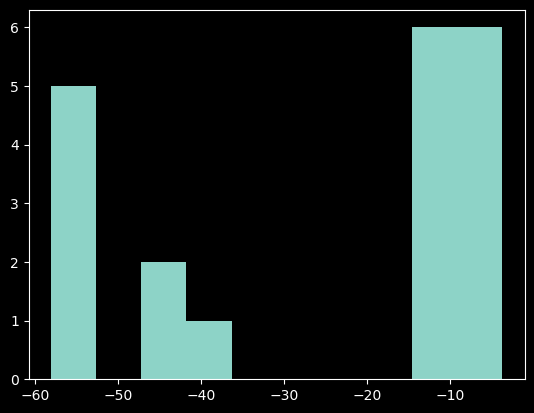

In [70]:
# Fitness

powers = np.arange(pop1.genome_size - 1)
outputs = genome[:, 1:] @ (env1.inputs ** powers)

fitnesses = - np.abs(outputs - env1.targets)
plt.hist(fitnesses)

(array([5., 0., 2., 1., 0., 0., 0., 0., 6., 6.]),
 array([-58.11263813, -52.67782357, -47.24300901, -41.80819445,
        -36.3733799 , -30.93856534, -25.50375078, -20.06893623,
        -14.63412167,  -9.19930711,  -3.76449255]),
 <BarContainer object of 10 artists>)

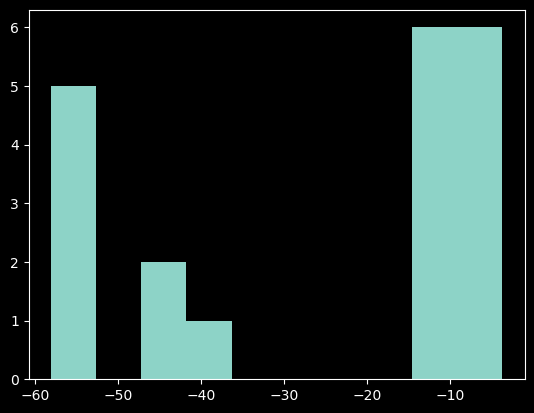

In [71]:
plt.hist(fitnesses)

In [72]:
# Crossover
N, genome_size = genome.shape
idx = np.arange(N)
rng.shuffle(idx)
new_population = genome.copy()
for i in range(0, N-1, 2):
    if rng.random() < 0.8:
        point = rng.integers(1, genome_size)
        p1, p2 = new_population[idx[i]].copy(), new_population[idx[i+1]].copy()
        new_population[idx[i], point:] = p2[point:]
        new_population[idx[i+1], point:] = p1[point:]
new_population = np.vstack((genome, new_population))
genome = new_population
genome.shape

(40, 5)

In [73]:
# Mutate

np.array(rng.random(genome.shape) < 0.1, dtype=int)

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [74]:
# Fitness

powers = np.arange(genome_size - 1)
outputs = genome[:, 1:] @ (env1.inputs ** powers)

fitnesses = - np.abs(outputs - env1.targets)
fitnesses.shape

(40,)

In [75]:
# Tournament selection

N = genome.shape[0]
idx = np.arange(N)
rng.shuffle(idx)
winners = []
for i in range(0, N, 2):
    competitors = idx[i:i+2]
    winner = competitors[np.argmax(fitnesses[competitors])]
    winners.append(winner)

genome = genome[winners]

In [76]:
# Fitness

powers = np.arange(genome_size - 1)
outputs = genome[:, 1:] @ (env1.inputs ** powers)

fitnesses = - np.abs(outputs - env1.targets)
fitnesses.shape

(20,)

In [77]:
# Migration Check

pop1.genome.shape

(20, 5)

In [86]:
pop1.migrate_to(pop2)

In [87]:
pop1.genome.shape

(8, 5)

In [90]:

pop2.genome.shape

(32, 5)

In [91]:
pop1.one_point_crossover()
pop1.genome.shape

(32, 5)

In [55]:
pop2.migrate_to(pop1)

In [57]:
pop1.genome.shape

(72, 5)

In [59]:
travel_mask = pop1.metadata['travel'] == 1

In [ ]:
pop2.migrate_to(pop1

(72, 5)

In [94]:
fitnesses = pop1.compute_fitness(env1.targets, env1.inputs)
pop1.tournament_selection(fitnesses)
pop1.genome.shape

(16, 5)